# Figure 1 updates
- Reviewer 1 suggested boxes instead of lines for better visual distinction -- perhaps possible with "hist" call?
- Consider the plotting regions more carefully -- why should figure 2 not overlap with the area of figure 3?

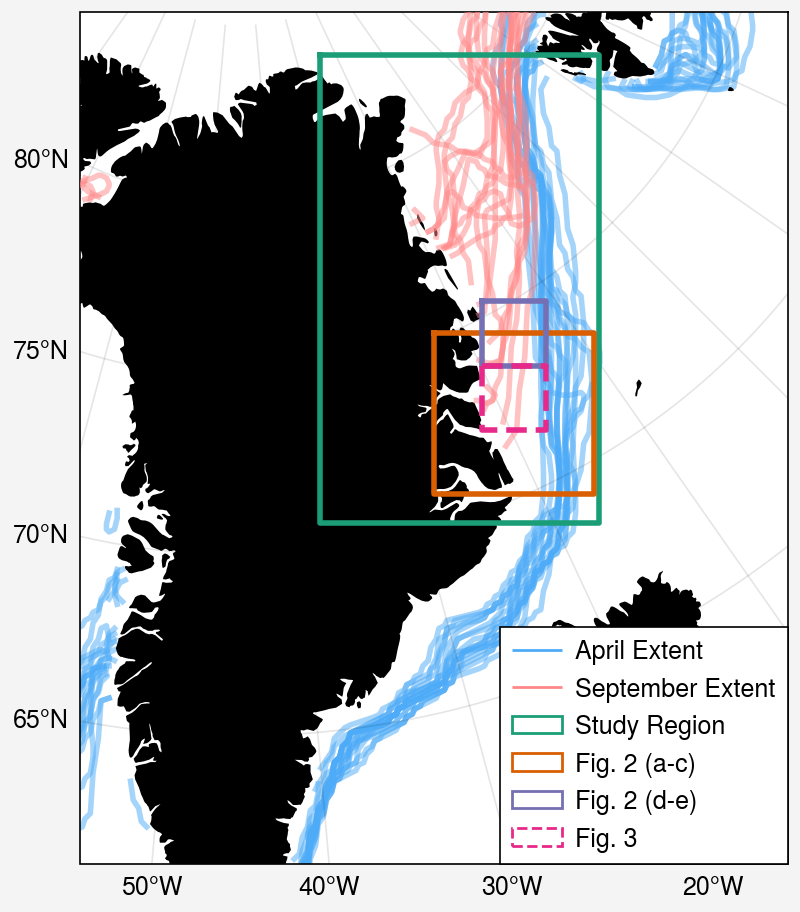

In [24]:
%run ../scripts/01_plot_study_region.py

In [26]:
x0 = 850
y0 = -1700
xlims = (0.75e6, 0.95e6)
ylims = (-1.8e6, -1.6e6)

(750, 950)

# Figure 2
Reviewer 1: "If I understand correctly, panels d and e are intended as zoomed-in views of panels a–c. However, based on their coordinates, they appear to extend beyond the spatial range of panels a–c. Please clarify this apparent inconsistency."
- That is inconsistent, and should be fixed. 

Reviewer 2: Missing units in Fig 2f.

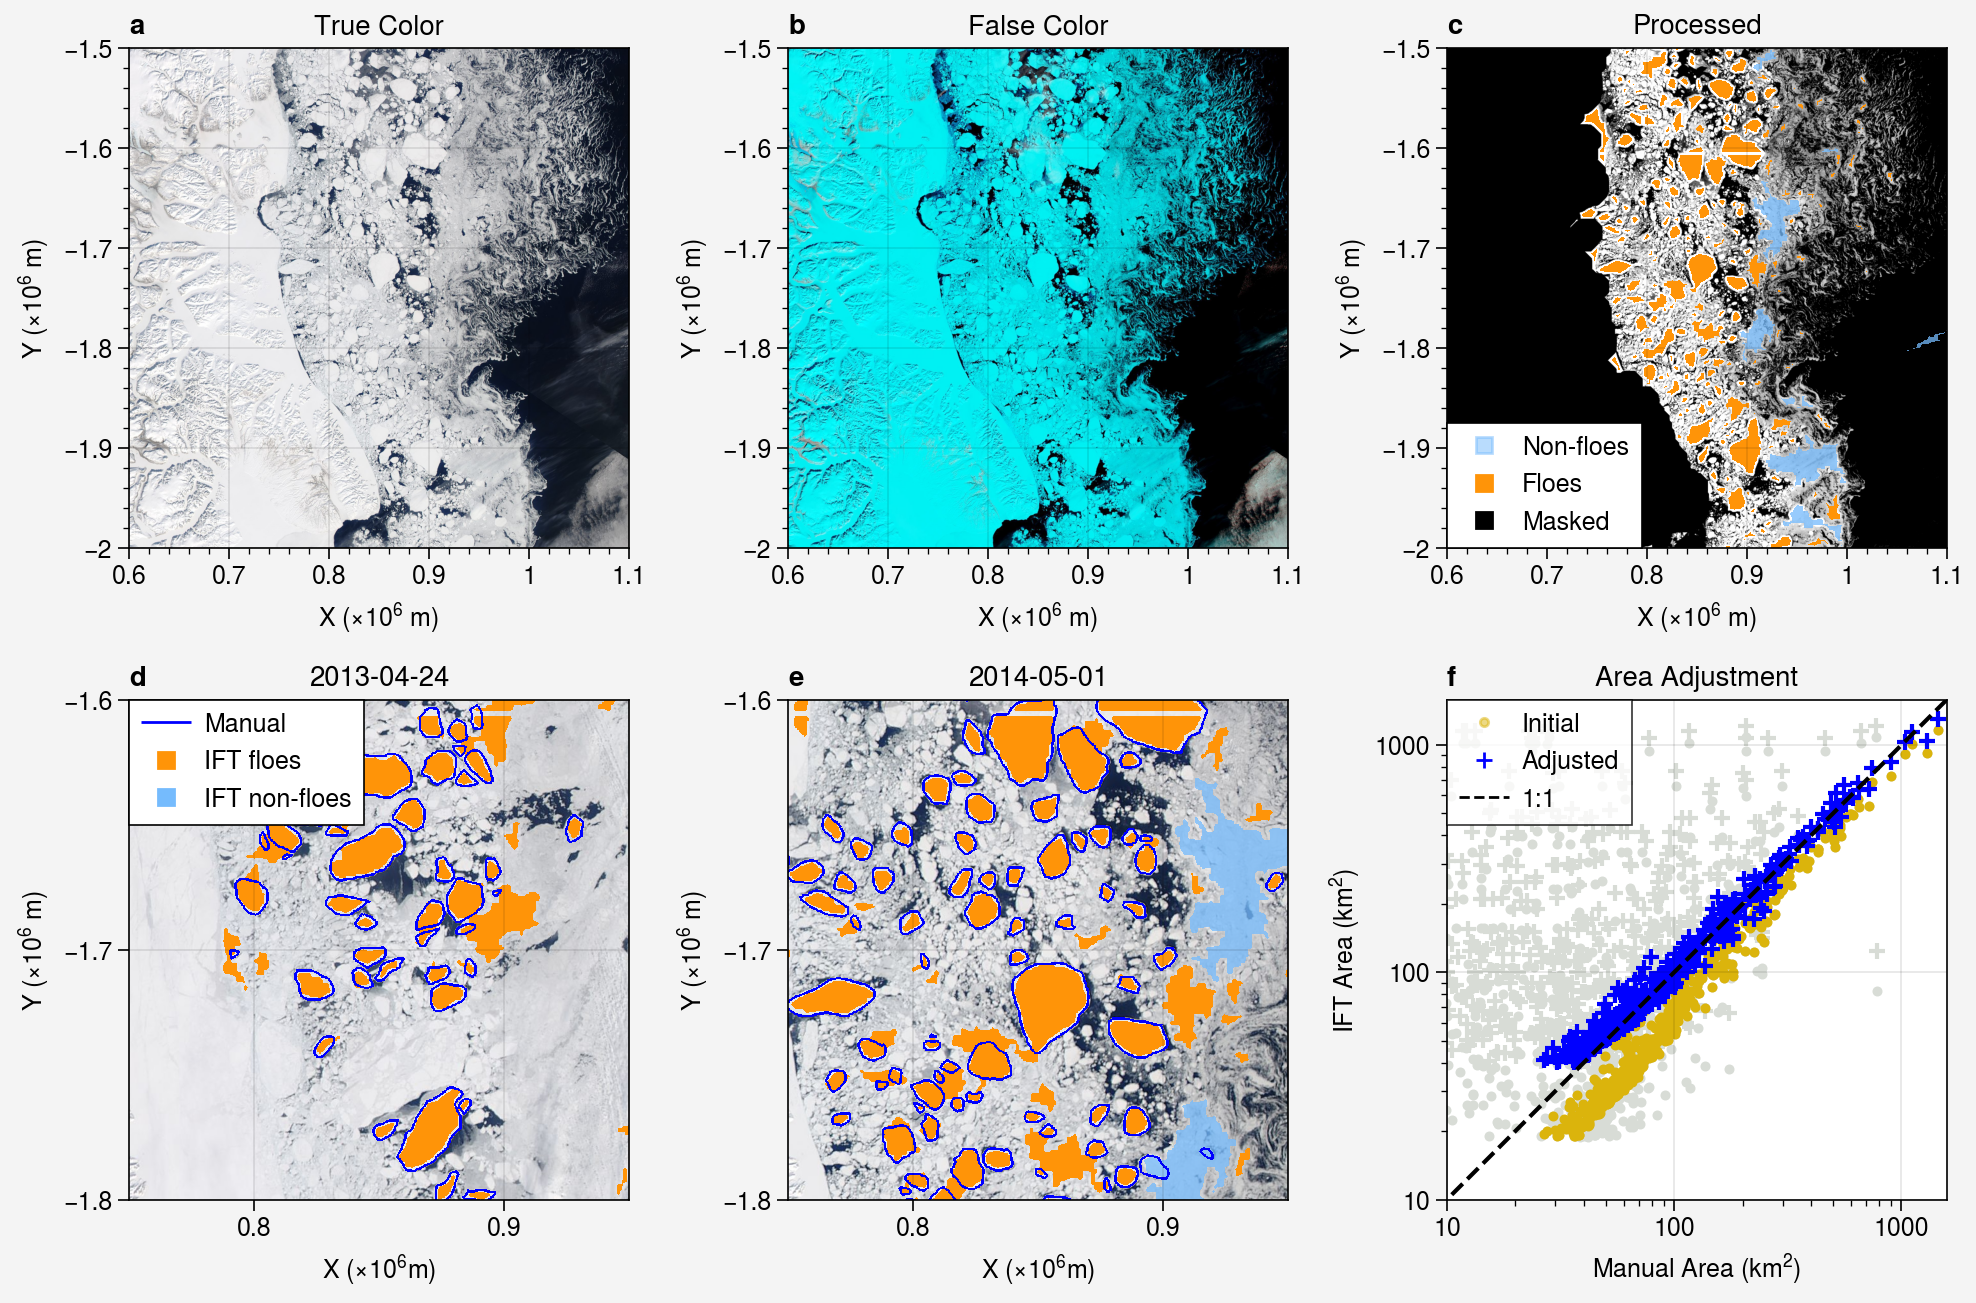

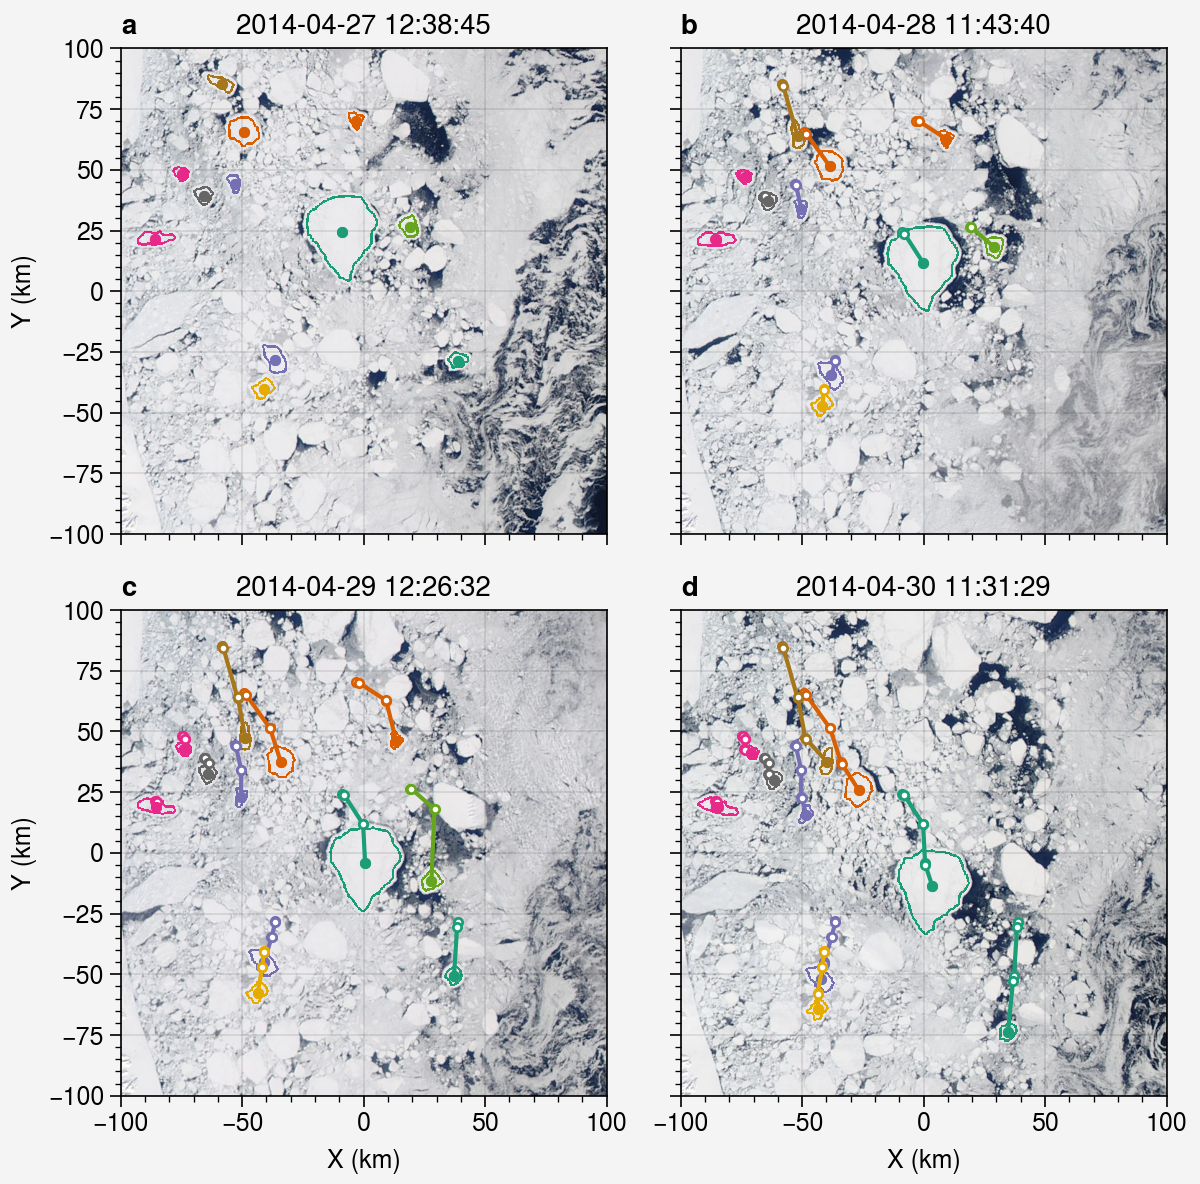

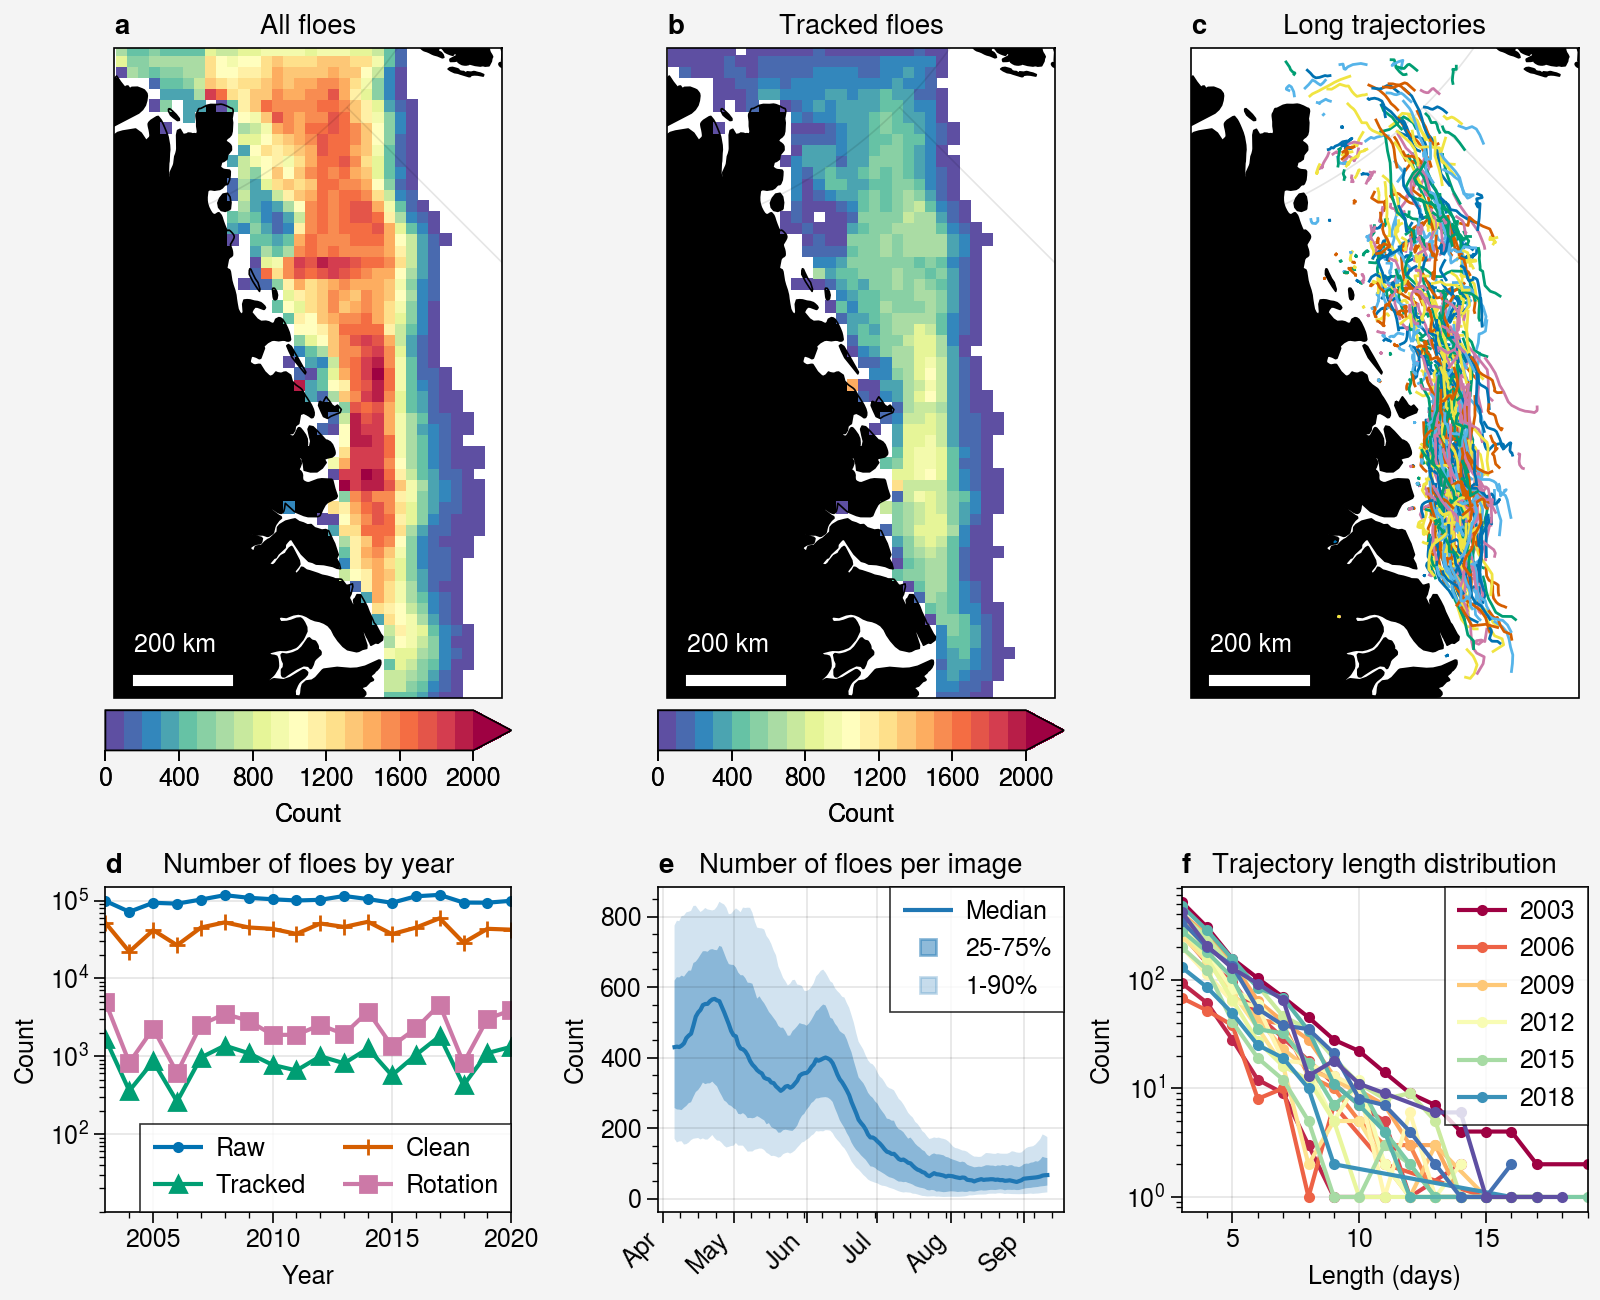

In [29]:
%run ../scripts/03_plot_data_summary.py

# Figures 11 and 12

Reviewer 2:

Reviewer 1:

Month 4 mean difference 0.09
Month 5 mean difference 0.09
Month 6 mean difference 0.11
31D U_along 7.995 cm/s
Fitted exponential dist. scale param: 0.74
31D U_fluctuating 6.341 cm/s
Fitted exponential dist. scale param: 0.75


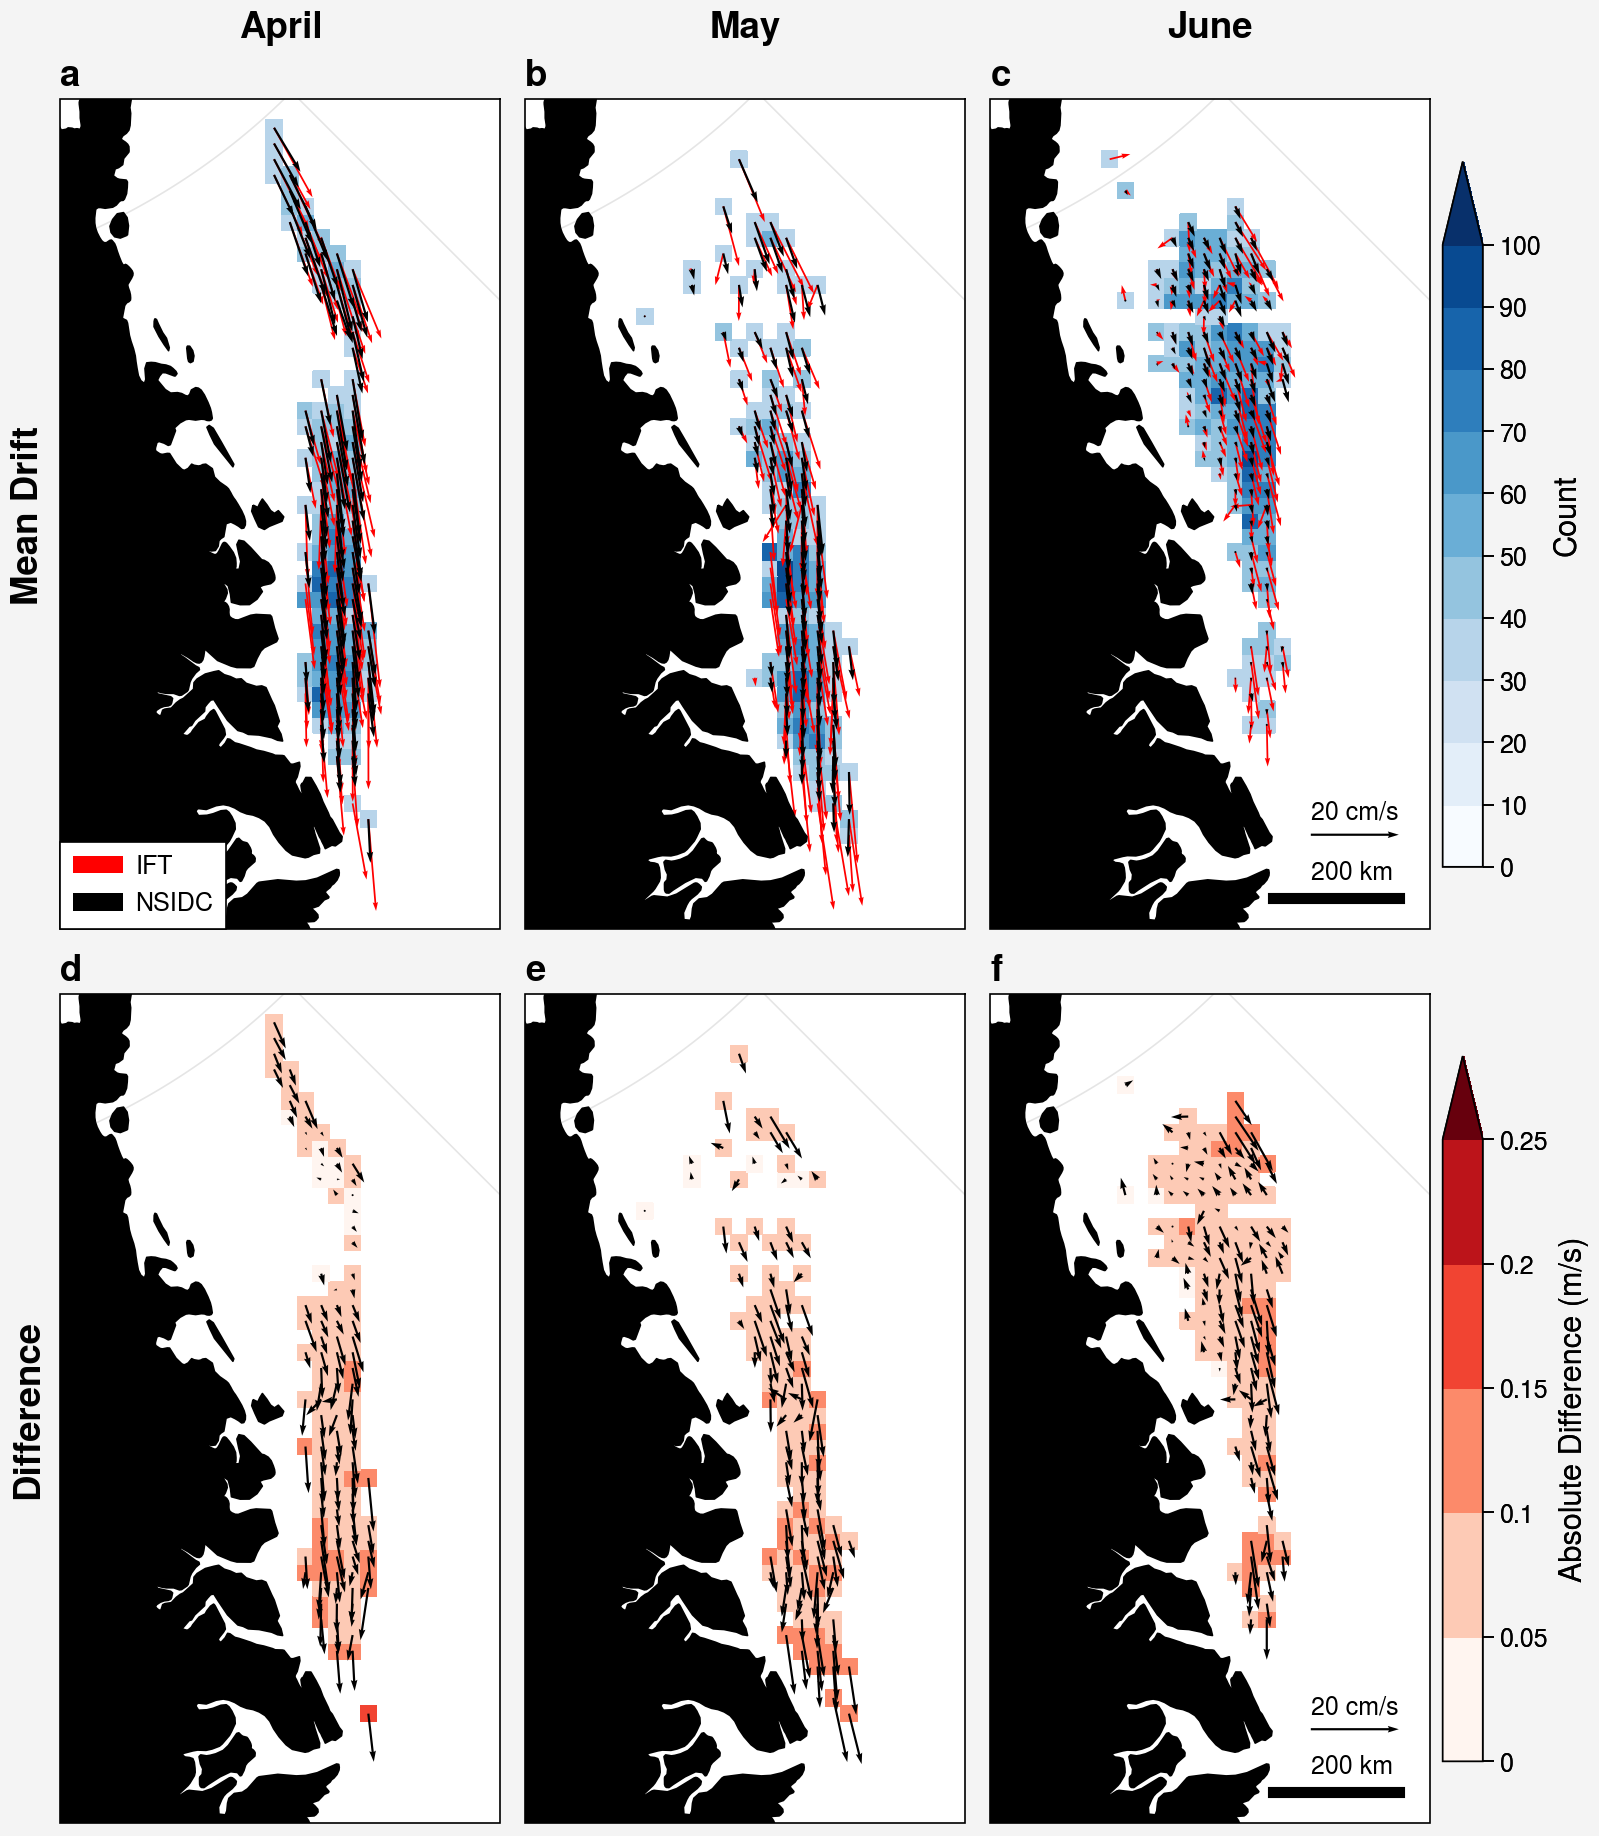

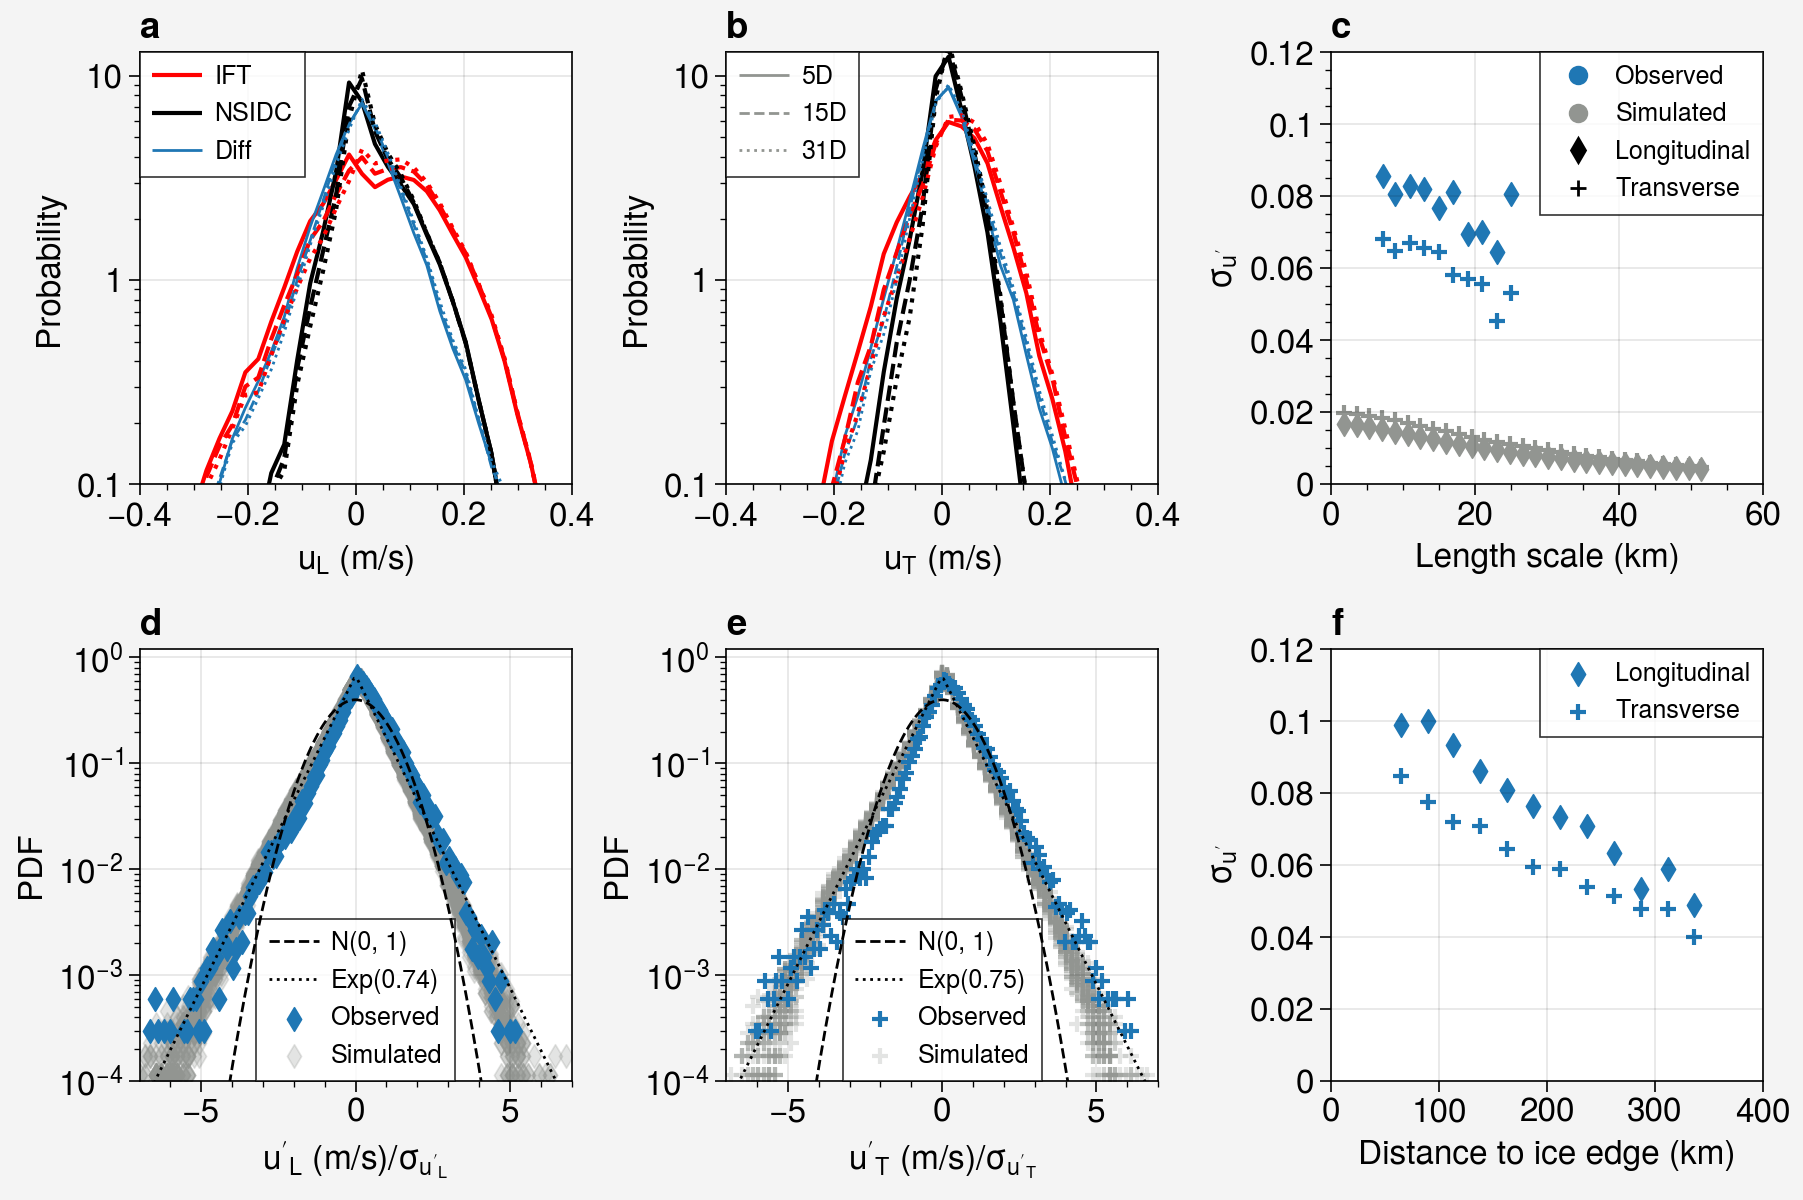

In [17]:
%run ../scripts/07_velocity_figures.py

In [58]:
pass_times = pd.DataFrame([
['2014-04-27 12:39:06',   'aqua'],
['2014-04-27 13:55:48',   'terra'],
['2014-04-28 11:44:06',	'aqua'],
['2014-04-28 14:38:44',	'terra'],
['2014-04-29 12:26:54',	'aqua'],
['2014-04-29 13:43:46',	'terra'],
['2014-04-30 13:09:48',	'aqua'],
['2014-04-30 14:26:34',	'terra']], columns=['datetime', 'satellite'])
pass_times['datetime'] = pd.to_datetime(pass_times['datetime'].values)
pass_times.sort_values('datetime', inplace=True)

data_loc = '../data/example_images_extended/'

# load images
tc_images = {}
floe_images_clean = {}
floe_images_raw = {}

for date, satellite in zip(pass_times['datetime'], pass_times['satellite']):
    tc_images[date] = rio.open('../data/example_images_extended//{d}.{s}.truecolor.250m.tiff'.format(d=date.strftime('%Y%m%d'), s=satellite))
    floe_images_raw[date] = rio.open('../data/example_images_extended/{d}.{s}.labeled_raw.250m.tiff'.format(d=date.strftime('%Y%m%d'), s=satellite))
    floe_images_clean[date] = rio.open('../data/example_images_extended/{d}.{s}.labeled_clean.250m.tiff'.format(d=date.strftime('%Y%m%d'), s=satellite))

TODO: Datetime alignment
- The dates in the tracked floe CSV file don't perfectly match the dates in the SOIT file.

NameError: name 'Images' is not defined

In [60]:
floe = '2014_01741'
comp_floe_loc = plot_floes.loc[plot_floes.floe_id == floe, ['x_stere', 'y_stere']].mean()
dx = 1e5
dy = 1e5
nearby_floes = plot_floes.loc[np.sqrt((plot_floes.x_stere - comp_floe_loc.x_stere)**2 + \
                                      (plot_floes.y_stere - comp_floe_loc.y_stere)**2) < dx]
nearby_floes = nearby_floes.groupby('floe_id').filter(lambda x: np.sum([d in x.datetime.values for d in plot_dates])>2)
floes = np.unique(nearby_floes.floe_id)

In [61]:
imdate = pd.to_datetime('2014-04-27 12:39:06')
left, bottom, right, top = tc_images[imdate].bounds
left /= 1e3
bottom /= 1e3
right /= 1e3
top /= 1e3

x0 = 850
y0 = -1700
left -= x0
right -= x0
top -= y0
bottom -= y0

floe = '2014_01741'
comp_floe_loc = plot_floes.loc[plot_floes.floe_id == floe, ['x_stere', 'y_stere']].mean()
dx = 1e5
dy = 1e5
nearby_floes = plot_floes.loc[np.sqrt((plot_floes.x_stere - comp_floe_loc.x_stere)**2 + \
                                      (plot_floes.y_stere - comp_floe_loc.y_stere)**2) < dx]
nearby_floes = nearby_floes.groupby('floe_id').filter(lambda x: np.sum([d in x.datetime.values for d in plot_dates])>2)
floes = np.unique(nearby_floes.floe_id)
colors = [c['color'] for c in pplt.Cycle('Dark2', len(floes))]
colors = {f_id: c for f_id, c in zip(floes, colors)}
    
for idx in np.arange(0, 8, 2):
    fig, ax = pplt.subplots(width=6, spanx=False, spany=False)
    

    date_aqua = pass_times.loc[idx, 'datetime']
    date_terra = pass_times.loc[idx + 1, 'datetime'] 
    
    ax.imshow(reshape_as_image(tc_images[date_aqua].read()), extent=[left, right, bottom, top])
    for date, color in zip([date_aqua, date_terra], ['r', 'b']):
        image = floe_images_clean[date].read().squeeze()
        outlines = image - skimage.morphology.erosion(image, skimage.morphology.disk(2))
        ax.pcolorfast(np.linspace(left, right, outlines.shape[1]),
              np.linspace(top, bottom, outlines.shape[0]),
              np.ma.masked_array(outlines, mask=outlines == 0), color=color)
    plot_df = plot_floes.loc[(plot_floes.datetime.dt.date == date_aqua.date()) & (plot_floes.satellite == 'aqua')]
    ax.scatter(plot_df.x_stere/1e3 - x0, plot_df.y_stere/1e3 - y0, color='r', marker='s', ms=4)

    plot_df = plot_floes.loc[(plot_floes.datetime.dt.date == date_terra.date()) & (plot_floes.satellite == 'terra')]
    ax.scatter(plot_df.x_stere/1e3 - x0, plot_df.y_stere/1e3 - y0, color='b', marker='.', ms=4)

    for floe in colors:
        c = colors[floe]
        df_floe = plot_floes.loc[plot_floes.floe_id == floe].set_index('datetime')

        # Plot the main tracked floe
        for floe_date in df_floe.index:
            if floe_date <= date:
                ax.pcolorfast(np.linspace(left, right, outlines.shape[1]),
                      np.linspace(top, bottom, outlines.shape[0]),
                      np.ma.masked_array(outlines, mask=outlines != df_floe.loc[floe_date, 'label']), color=c, zorder=10)
        
                ax.plot(df_floe.loc[df_floe.index <= date, 'x_stere'].values/1e3 - x0,
                        df_floe.loc[df_floe.index <= date, 'y_stere'].values/1e3 - y0, color=c, marker='.', facecolor='w')
                ax.plot(df_floe.loc[floe_date, 'x_stere']/1e3 - x0,
                        df_floe.loc[floe_date, 'y_stere']/1e3 - y0, color=c, marker='.')    

    ax.format(title=date.strftime('%Y-%m-%d (raw shapes)'), yreverse=False, ylim=(-100, 100), xlim=(-100, 100),)
    fig.save('../figures/test_fig3_tracking_clean_' + date.strftime('%Y%m%d') + '.png', dpi=300)
    pplt.close(fig)

In [73]:
plot_floes.sort_values('area')[::-1].groupby('floe_id').filter(lambda x: len(x) > 4)

level_0  level_1            datetime satellite     floe_id  label  \
420580     2014    20144 2014-04-24 12:08:04      aqua  2014_01310    146   
420881     2014    20642 2014-04-24 13:25:02     terra  2014_01310    159   
418753     2014    17918 2014-04-22 12:20:22      aqua  2014_01310    113   
419186     2014    18424 2014-04-22 13:37:19     terra  2014_01310    136   
422362     2014    22953 2014-04-27 12:38:45      aqua  2014_01310    161   
...         ...      ...                 ...       ...         ...    ...   
425616     2014    27988 2014-05-02 11:19:18      aqua  2014_02075    240   
423730     2014    25078 2014-04-29 12:26:32      aqua  2014_01985    348   
423250     2014    24182 2014-04-28 11:43:40      aqua  2014_01985    210   
424057     2014    25592 2014-04-29 13:43:33     terra  2014_01983    230   
425603     2014    27975 2014-05-02 11:19:18      aqua  2014_01985    138   

        longitude  latitude   x_stere    y_stere  ...  tc_channel2  \
420580    -3.4834   79.2892  771227.3  -871203.7  ...        233.5   
420881    -3.5723   79.2690  771335.6  -874055.0  ...        234.1   
418753    -2.8402   79.5964  758436.9  -837618.9  ...        231.7   
419186    -2.8442   79.5702  760301.1  -839794.9  ...        231.4   
422362    -5.0733   78.6622  790742.2  -944821.0  ...        231.9   
...           ...       ...       ...        ...  ...          ...   
425616   -20.4077   70.1797  902182.6 -1971239.8  ...        233.5   
423730   -18.6450   72.7406  836083.7 -1687606.7  ...        234.5   
423250   -18.3657   72.8875  837008.3 -1668972.3  ...        233.1   
424057   -18.8358   73.1300  811458.2 -1651703.4  ...        229.6   
425603   -18.9545   72.5274  837320.0 -1713307.5  ...        232.8   

        fc_channel0  fc_channel1  fc_channel2  init_classification  \
420580         17.8        239.3        241.4                   TP   
420881         12.4        239.5        240.9                   TP   
418753          1.5        236.3        238.7                   TP   
419186          0.6        236.8        239.0                   TP   
422362         25.4        238.7        240.2                   TP   
...             ...          ...          ...                  ...   
425616         36.1        239.4        243.7                   TP   
423730          2.7        240.4        241.2                   TP   
423250          2.2        239.8        242.5                   TP   
424057          4.2        236.4        239.2                   TP   
425603          2.2        238.9        242.2                   TP   

        lr_probability  lr_classification  final_classification  doy  year  
420580           0.964               True                  True  114  2014  
420881           0.970               True                  True  114  2014  
418753           0.958               True                  True  112  2014  
419186           0.991               True                  True  112  2014  
422362           0.977               True                  True  117  2014  
...                ...                ...                   ...  ...   ...  
425616           0.997               True                  True  122  2014  
423730           1.000               True                  True  119  2014  
423250           1.000               True                  True  118  2014  
424057           0.999               True                  True  119  2014  
425603           0.999               True                  True  122  2014  

[605 rows x 42 columns]

In [74]:
plot_floes.loc[plot_floes.floe_id == '2014_01310', ['floe_id', 'label', 'datetime', 'area']]

floe_id  label            datetime     area
418753  2014_01310    113 2014-04-22 12:20:22  27261.0
419186  2014_01310    136 2014-04-22 13:37:19  27197.0
420580  2014_01310    146 2014-04-24 12:08:04  27883.0
420881  2014_01310    159 2014-04-24 13:25:02  27687.0
421584  2014_01310    189 2014-04-26 11:55:52  26971.0
421923  2014_01310    210 2014-04-26 13:12:44  25756.0
422362  2014_01310    161 2014-04-27 12:38:45  27176.0

In [47]:
date.round('1h')

Timestamp('2014-04-30 14:00:00')

In [24]:
imdate = pd.to_datetime('2014-04-27 12:38:45')
plot_floes = floe_lib_clean.loc[(floe_lib_clean.floe_id != 'unmatched') &
    (floe_lib_clean.datetime.dt.year == imdate.year)].groupby('floe_id').filter(lambda x: np.any((x.datetime > '2014-04-27') & (x.datetime <= '2014-04-30')))


In [34]:
colors = [c['color'] for c in pplt.Cycle('Dark2', 12)]


level_0  level_1            datetime satellite     floe_id  label  \
424395     2014    26048 2014-04-30 11:31:29      aqua  2014_02089    320   
424396     2014    26049 2014-04-30 11:31:29      aqua  2014_02090    387   
424397     2014    26050 2014-04-30 11:31:29      aqua  2014_02091    155   
424398     2014    26051 2014-04-30 11:31:29      aqua  2014_02093    136   
424399     2014    26052 2014-04-30 11:31:29      aqua  2014_02094    532   
...         ...      ...                 ...       ...         ...    ...   
424489     2014    26167 2014-04-30 11:31:29      aqua  2014_02014    330   
424490     2014    26168 2014-04-30 11:31:29      aqua  2014_02017    153   
424491     2014    26169 2014-04-30 11:31:29      aqua  2014_02018    254   
424492     2014    26170 2014-04-30 11:31:29      aqua  2014_02005    412   
424493     2014    26172 2014-04-30 11:31:29      aqua  2014_01770    193   

        longitude  latitude   x_stere    y_stere  ...  tc_channel2  \
424395    -8.1892   77.0252  845624.1 -1129924.7  ...        228.1   
424396     6.9735   79.8068  872019.8  -681946.9  ...        220.4   
424397    -5.9409   78.6162  779516.7  -960594.6  ...        227.5   
424398    -7.4897   78.3890  768400.3 -1001027.1  ...        226.1   
424399   -18.9904   69.9805  960407.2 -1968285.3  ...        232.1   
...           ...       ...       ...        ...  ...          ...   
424489   -13.8093   74.8278  855992.0 -1413930.9  ...        227.3   
424490   -18.7057   73.8827  778357.2 -1575277.8  ...        228.8   
424491    -2.0586   78.8658  824176.3  -885635.4  ...        225.7   
424492   -20.5544   70.4344  885387.8 -1947703.1  ...        235.1   
424493   -20.8359   72.2510  793161.6 -1767825.7  ...        233.6   

        fc_channel0  fc_channel1  fc_channel2  init_classification  \
424395        165.5        232.1        236.5                   TP   
424396        155.2        228.6        230.8                   TP   
424397        169.3        231.4        235.0                   TP   
424398        168.6        230.0        234.1                   TP   
424399          1.0        236.7        242.8                   TP   
...             ...          ...          ...                  ...   
424489          5.0        237.3        239.5                   TP   
424490          2.1        235.2        239.8                   TP   
424491        161.6        231.3        234.4                   TP   
424492          0.8        240.0        242.5                   TP   
424493          1.2        237.5        240.9                   TP   

        lr_probability  lr_classification  final_classification  doy  year  
424395           0.492              False                  True  120  2014  
424396           0.348              False                  True  120  2014  
424397           0.548               True                  True  120  2014  
424398           0.400              False                  True  120  2014  
424399           0.999               True                  True  120  2014  
...                ...                ...                   ...  ...   ...  
424489           0.978               True                  True  120  2014  
424490           0.996               True                  True  120  2014  
424491           0.273              False                  True  120  2014  
424492           0.997               True                  True  120  2014  
424493           0.998               True                  True  120  2014  

[86 rows x 42 columns]

In [ ]:
# Dates with multiple tracked floes, all from the Aqua satellite
plot_dates = [pd.to_datetime(x) for x in ['2014-04-27 12:38:45', '2014-04-28 11:43:40',
                                          '2014-04-29 12:26:32', '2014-04-30 11:31:29']]

# load images
tc_images = {}
floe_images = {}

for date in plot_dates:
    tc_images[date] = rio.open('../data/example_images/{d}.aqua.truecolor.250m.tiff'.format(d=date.strftime('%Y%m%d')))
    floe_images[date] = rio.open('../data/example_images/{d}.aqua.labeled_clean.250m.tiff'.format(d=date.strftime('%Y%m%d')))

imdate = pd.to_datetime('2014-04-27 12:38:45')
plot_floes = floe_lib_clean.loc[(floe_lib_clean.floe_id != 'unmatched') & (floe_lib_clean.datetime.dt.year == imdate.year)].groupby('floe_id').filter(lambda x: imdate in x.datetime.values)

# get nearby floes that have enough dates
floe = '2014_01741'
comp_floe_loc = plot_floes.loc[plot_floes.floe_id == floe, ['x_stere', 'y_stere']].mean()
dx = 1e5
dy = 1e5
nearby_floes = plot_floes.loc[np.sqrt((plot_floes.x_stere - comp_floe_loc.x_stere)**2 + \
                                      (plot_floes.y_stere - comp_floe_loc.y_stere)**2) < dx]
nearby_floes = nearby_floes.groupby('floe_id').filter(lambda x: np.sum([d in x.datetime.values for d in plot_dates])>2)
floes = np.unique(nearby_floes.floe_id)

left, bottom, right, top = tc_images[imdate].bounds
left /= 1e3
bottom /= 1e3
right /= 1e3
top /= 1e3

x0 = 850
y0 = -1700
left -= x0
right -= x0
top -= y0
bottom -= y0

fig, axs = pplt.subplots(ncols=2, nrows=2, width=6, spanx=False, spany=False)

colors = [c['color'] for c in pplt.Cycle('Dark2', 12)]

for ax, date in zip(axs,plot_dates):
    ax.imshow(reshape_as_image(tc_images[date].read()), extent=[left, right, bottom, top])
    image = floe_images[date].read().squeeze()
    
    outlines = image - skimage.morphology.erosion(image, skimage.morphology.disk(4))

    for c, floe in zip(colors, floes):
        df_floe = plot_floes.loc[plot_floes.floe_id == floe].set_index('datetime')

        # Plot the main tracked floe
        if date in df_floe.index:
            ax.pcolorfast(np.linspace(left, right, outlines.shape[1]),
                  np.linspace(top, bottom, outlines.shape[0]),
                  np.ma.masked_array(outlines, mask=outlines != df_floe.loc[date, 'label']), color=c)

            ax.plot(df_floe.loc[df_floe.index <= date, 'x_stere'].values/1e3 - x0,
                    df_floe.loc[df_floe.index <= date, 'y_stere'].values/1e3 - y0, color=c, marker='.', facecolor='w')
            ax.plot(df_floe.loc[date, 'x_stere']/1e3 - x0,
                    df_floe.loc[date, 'y_stere']/1e3 - y0, color=c, marker='.')
            
    ax.format(ylim=(-100, 100), xlim=(-100, 100), title=date, ylabel='Y (km)', xlabel='X (km)')
axs.format(abc=True)
fig.save('../figures/fig03_tracked_floes.png', dpi=300)
fig.save('../figures/fig03_tracked_floes.pdf', dpi=300)
pplt.close(fig)

In [ ]:
# getting the nearby floes